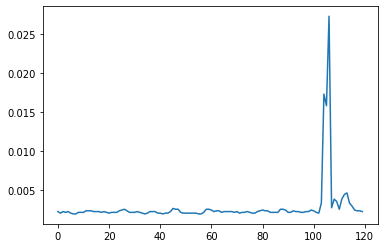

In [15]:
import sys

sys.path.append('../')
from tsdr import tsdr

import matplotlib.pyplot as plt
import numpy as np

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
short_spike_series = data_df['s-user_latency'].to_numpy()
plt.plot(short_spike_series)

In [2]:
from numpy.lib.stride_tricks import sliding_window_view
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

sel = ar_select_order(short_spike_series, maxlag=int(short_spike_series.size*0.1), ic='aic')
model_fit = sel.model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  120
Model:                     AutoReg(5)   Log Likelihood                 534.216
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Mon, 31 Jan 2022   AIC                          -1054.431
Time:                        00:06:29   BIC                          -1035.217
Sample:                             5   HQIC                         -1046.632
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.888      0.004       0.000       0.002
y.L1           0.5113      0.092      5.580      0.000       0.332       0.691
y.L2           0.3393      0.103      3.287      0.0

In [3]:
r = model_fit.ar_lags[-1]
windows = sliding_window_view(short_spike_series, r)
sig2 = model_fit.sigma2
coef = model_fit.params

# xi = short_spike_series
pred = model_fit.get_prediction()
print(pred.summary_frame())

         mean   mean_se  mean_ci_lower  mean_ci_upper
0         NaN       NaN            NaN            NaN
1         NaN       NaN            NaN            NaN
2         NaN       NaN            NaN            NaN
3         NaN       NaN            NaN            NaN
4         NaN       NaN            NaN            NaN
..        ...       ...            ...            ...
115  0.002939  0.002324      -0.001617       0.007495
116  0.002434  0.002324      -0.002122       0.006989
117  0.002645  0.002324      -0.001911       0.007201
118  0.002667  0.002324      -0.001889       0.007223
119  0.002600  0.002324      -0.001956       0.007156

[120 rows x 4 columns]


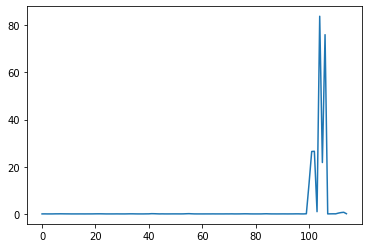

In [5]:
preds = pred.summary_frame()[r:]['mean'].to_numpy()

scores = []
for i, x in enumerate(short_spike_series):
    if i >= short_spike_series.size - r:
        break
    scores.append((x - preds[i]) ** 2 / sig2)

plt.plot(scores)

In [16]:
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
import numpy as np

class ARAD:
    maxlag: int
    def __init__(self, maxlag: int = 0):
        self.maxlag = maxlag
    
    def score(self, x: np.ndarray, lags: int = 0, regression: str = 'c', autolag: bool = True, ic: str = 'aic') -> tuple[list[float], list[float], int]:
        model_fit = None
        r: int = 0
        if autolag:
            maxlag = int(x.size * 0.2) if self.maxlag == 0 else self.maxlag
            sel = ar_select_order(x, maxlag=maxlag, trend=regression, ic=ic)
            model_fit = sel.model.fit()
        else:
            reg = AutoReg(x, lags=lags, trend=regression)
            model_fit = reg.fit()
        if model_fit.ar_lags is None or len(model_fit.ar_lags) > 0:
            r = model_fit.ar_lags[-1]
        sig2 = model_fit.sigma2

        pred = model_fit.get_prediction()
        preds = pred.summary_frame()[r:]['mean'].to_numpy()

        scores: list[float] = []
        for i, xi in enumerate(x[r:]):
            if i >= preds.size:
                break
            scores.append((xi - preds[i]) ** 2 / sig2)
        return scores, preds.tolist(), r


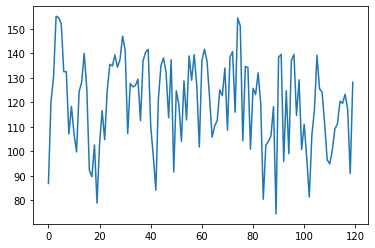

In [17]:
# White-noise
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-cpu-hog_2.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
white_noise_series = data_df['c-orders_network_receive_packets_total'].to_numpy()
plt.plot(white_noise_series)

In [18]:
from scipy.stats import zscore

r:  6


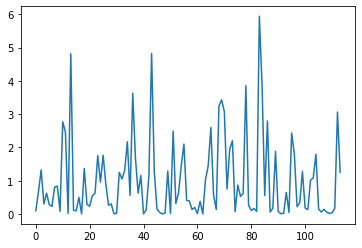

In [19]:
arad = ARAD()
scores, preds, r = arad.score(zscore(white_noise_series))
print('r: ', r)
plt.plot(scores)

r:  3


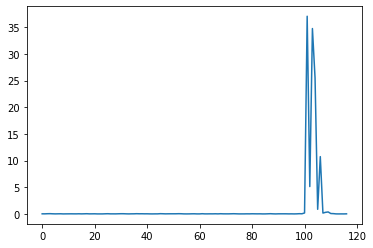

In [20]:
arad = ARAD()
scores, preds, r = arad.score(zscore(short_spike_series))
print('r: ', r)
plt.plot(scores)

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       16., 14.])

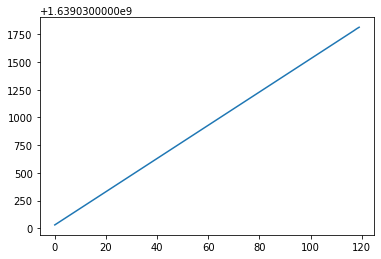

In [21]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user-db_pod-cpu-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
liner_series = data_df['c-catalogue_last_seen'].to_numpy()
plt.plot(liner_series)
np.diff(liner_series)

r:  24


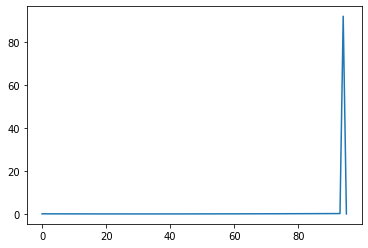

In [24]:
arad = ARAD()
scores, preds, r = arad.score(zscore(liner_series))
print('r: ', r)
plt.plot(scores)

c-user_memory_working_set_bytes


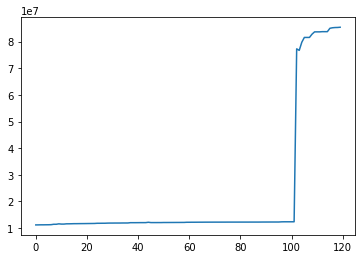

In [25]:
import matplotlib.pyplot as plt

sys.path.append('../tests')
from testseries.sockshop import testcases_of_sockshop

case5 = testcases_of_sockshop[4]
print(case5['name'])
plt.plot(case5['datapoints'])

r lag: 1


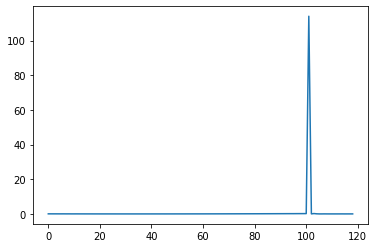

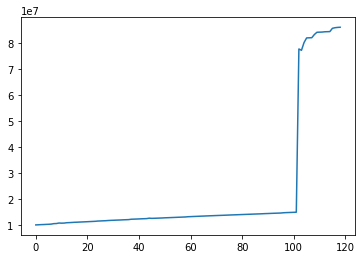

In [27]:
arad = ARAD()
scores, preds, r = arad.score(np.array(case5['datapoints']), regression='ct')
print('r lag:', r)
fig = plt.figure()
plt.plot(scores)
fig = plt.figure()
plt.plot(preds)

s-orders_latency02


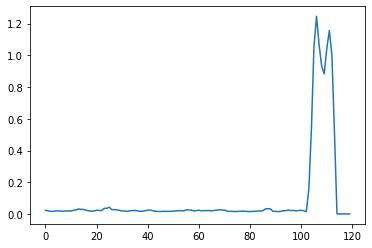

In [28]:
import matplotlib.pyplot as plt

sys.path.append('../tests')
from testseries.sockshop import testcases_of_sockshop

case7 = testcases_of_sockshop[6]
print(case7['name'])
plt.plot(case7['datapoints'])

r lag: 19


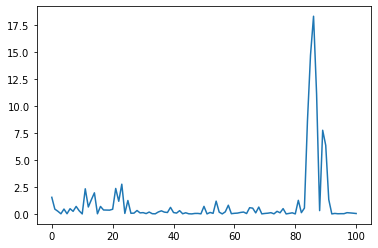

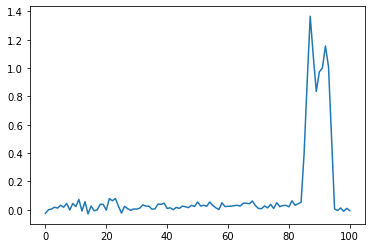

In [32]:
arad = ARAD()
scores, preds, r = arad.score(np.array(case7['datapoints']), regression='ct')
print('r lag:', r)
fig = plt.figure()
plt.plot(scores)
fig = plt.figure()
plt.plot(preds)

c-catalogue_last_seen


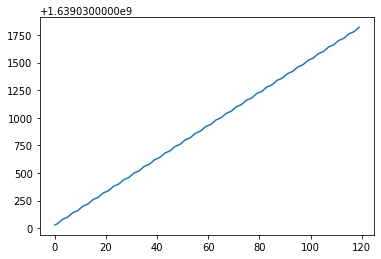

In [30]:
import matplotlib.pyplot as plt

sys.path.append('../tests')
from testseries.sockshop import testcases_of_sockshop

case2 = testcases_of_sockshop[1]
print(case2['name'])
plt.plot(case2['datapoints'])

r lag: 14
[0.9999990024457405, 0.9999990682253476, 0.999999101115152, 0.999999101115152, 0.9999990682253476, 0.9999990682253476, 0.9999991668947623, 0.9999991997845683, 0.9999991668947623, 0.9999991668947623, 0.999999265564182, 0.9999992326743748, 0.9999992326743748, 0.9999992326743748, 0.9999993313437977, 0.9999993313437977, 0.9999993313437977, 0.9999993313437977, 0.9999993971234156, 0.9999993971234156, 0.9999993642336064, 0.9999993642336064, 0.9999994629030357, 0.9999994957928465, 0.9999994629030357, 0.9999994629030357, 0.999999528682658, 0.9999995615724698, 0.9999994957928465, 0.999999528682658, 0.9999995944622824, 0.9999996273520954, 0.9999995944622824, 0.9999996273520954, 0.9999996602419089, 0.9999996931317231, 0.9999996602419089, 0.9999996602419089, 0.9999997589113528, 0.9999997918011686, 0.9999997589113528, 0.9999997918011686, 0.9999997918011686, 0.9999998575808017, 0.9999998246909849, 0.9999998575808017, 0.9999999233604369, 0.9999999233604369, 0.999999890470619, 0.9999999233604

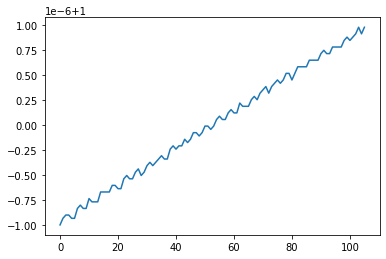

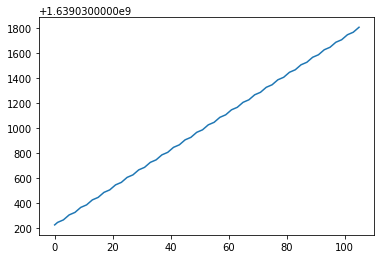

In [34]:
arad = ARAD()
scores, preds, r = arad.score(np.array(case2['datapoints']), regression='ct')
print('r lag:', r)
fig = plt.figure()
plt.plot(scores)
fig = plt.figure()
plt.plot(preds)

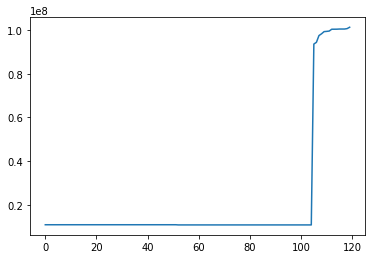

In [1]:
# Misdetected series with AR

# 'c-catalogue_memory_working_set_bytes'
misdetected_series3 = [
    10805248.0, 10805248.0, 10805248.0, 10805248.0, 10805248.0, 10805248.0,
    10809344.0, 10809344.0, 10809344.0, 10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10809344.0, 10809344.0,
                      10809344.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      10727424.0, 10727424.0, 10727424.0,
                      93597696.0, 94375936.0, 97480704.0,
                      98287616.0, 99287040.0, 99397632.0,
                      99545088.0, 100384768.0, 100388864.0,
                      100405248.0, 100474880.0, 100478976.0,
                      100478976.0, 100663296.0,
                      101294080.0]

import matplotlib.pyplot as plt
plt.plot(misdetected_series3)

In [42]:
import sys
sys.path.append('../')
%reload_ext autoreload
%autoreload 2
from tsdr import tsdr
from tsdr.outlierdetection.ar import AROutlierDetector
import numpy as np

ar = AROutlierDetector()
scores, preds, model = ar.score(
    x=np.array(misdetected_series3),
    regression='n',
    autolag=True,
)
model.plot_diagnostics()
print("Params: ", model.params)
print("Covariance Params: ", model.cov_params())
print(model.summary())

outliers = ar.detect_by_fitting_dist(scores, threshold=0.01)
print(outliers)

fig, axs = plt.subplots(2)
axs[0].plot(preds)
axs[1].plot(scores)

TypeError: super(type, obj): obj must be an instance or subtype of type

if start(1) - hold_back(1) <= nobs(119)
reg:  119 [10805248.] [1.00663296e+08]
_x:  119 [10805248.] [1.00663296e+08]
det_col_idx:  0
adj_dynamic:  1
forecasts:  119 10923323.97705785 101763309.34805676
after forecasts:  119 10923323.97705785 39384353.6879425
Params:  [1.01092765]
Covariance Params:  [[0.00038625]]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  120
Model:                     AutoReg(1)   Log Likelihood               -2054.156
Method:               Conditional MLE   S.D. of innovations        7594076.929
Date:                Thu, 10 Feb 2022   AIC                             31.719
Time:                        16:51:01   BIC                             31.766
Sample:                             1   HQIC                            31.738
                                  120                                         
                 coef    std err          z      P>|

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


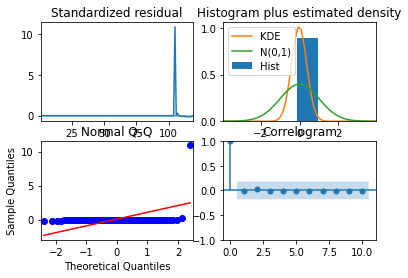

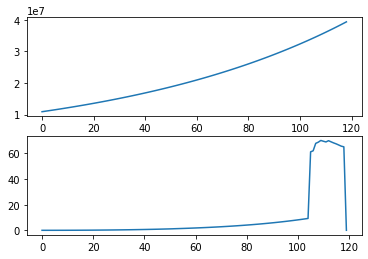

In [41]:
ar = AROutlierDetector()
scores, preds, model = ar.score(
    x=np.array(misdetected_series3),
    regression='n',
    autolag=True,
    dynamic_prediction=True,
)
model.plot_diagnostics()
print("Params: ", model.params)
print("Covariance Params: ", model.cov_params())
print(model.summary())

outliers = ar.detect_by_fitting_dist(scores, threshold=0.01)
print("Outliers: ", outliers)

fig, axs = plt.subplots(2)
axs[0].plot(preds)
axs[1].plot(scores)